In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import os
from torch import nn, optim, device, cuda, Tensor, LongTensor, argmax, bincount
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertForSequenceClassification, BertTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm
import random

In [ ]:
TEST_SIZE = 0.2

MAX_EPOCHS = 2
LEARNING_RATE = 5e-5
BATCH_SIZE = 16
MAX_LENGTH = 255

SAVE_MODEL = True
MODEL_FOLDER = '/content/drive/MyDrive/models/model_bert'
DATASET = '/content/drive/MyDrive/datasets/datasetall.csv'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
if SAVE_MODEL:
  os.makedirs(
    MODEL_FOLDER,
    exist_ok=True, # Create folder if it doesn't exist, else do nothing
  )

  print(f"Saving model at '{MODEL_FOLDER}'")

Saving model at '/content/drive/MyDrive/models/model_bert'


In [ ]:
def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

dataset = read_csv_file(DATASET)
dataset

CSV file read successfully!


,text,label
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0
2,wait so ur telling me Let Leni Lead mo pero NY...,1
3,[USERNAME]wish this is just a nightmare that ...,0
4,doc willie ong and isko sabunutan po,0
...,...,...
28456,"Bisaya, Probinsyano/a, mostly Bisaya = katulong",1
28457,Amnesia. In my whole life wala pa ako nakasala...,1
28458,Kontrabida na ilang beses na tinalo at obvious...,1
28459,Yung antagonist laging kailangang sobrang sama...,1


In [ ]:
def shuffle_data_frame(data_frame):
    text = list(data_frame['text'])
    label = list(data_frame['label'])

    assert(len(text) == len(label))

    indices = list(range(len(label)))

    # Make a random number generator that will shuffle list of indices
    # It is seeded to be reproducible
    random_number_generator = np.random.default_rng(seed=0)
    random_number_generator.shuffle(indices)

    shuffled_text = []
    shuffled_labels = []

    # Iterate through the list of indices and add the original data
    # from those shuffled indices
    for index in indices:
        shuffled_text.append(text[index])
        shuffled_labels.append(label[index])

    return pd.DataFrame({
        'text': shuffled_text,
        'label': shuffled_labels,
    })


def get_train_test_split(data_frame: pd.DataFrame, test_size: float):
    """
    Makes a stratified train test split.
    This aims to preserve the distribution between classes.
    """
    if not (1 > test_size > 0):
        print('ERROR: test_size must be between 0 and 1')
        return

    data_frame = shuffle_data_frame(data_frame)

    data_frame_length = len(data_frame)
    train_size = 1 - test_size

    nonhate_rows = data_frame[data_frame['label'] == 0]
    nonhate_row_length = len(nonhate_rows)

    nonhate_row_train_size = math.ceil(nonhate_row_length * train_size)

    nonhate_row_train = nonhate_rows[0:nonhate_row_train_size]
    nonhate_row_test = nonhate_rows[nonhate_row_train_size:nonhate_row_length]

    assert(len(nonhate_row_train) + len(nonhate_row_test) == nonhate_row_length)

    hate_rows = data_frame[data_frame['label'] == 1]
    hate_row_length = len(hate_rows)

    hate_row_train_size = math.ceil(hate_row_length * train_size)

    hate_row_train = hate_rows[0:hate_row_train_size]
    hate_row_test = hate_rows[hate_row_train_size:hate_row_length]

    assert(len(hate_row_train) + len(hate_row_test) == hate_row_length)

    combined_train = pd.concat([nonhate_row_train, hate_row_train])
    combined_test = pd.concat([nonhate_row_test, hate_row_test])

    shuffled_train = shuffle_data_frame(combined_train)
    shuffled_test = shuffle_data_frame(combined_test)

    return (
        shuffled_train['text'],
        shuffled_test['text'],
        shuffled_train['label'],
        shuffled_test['label'],
    )

X_train, X_test, y_train, y_test = get_train_test_split(dataset, TEST_SIZE)

In [ ]:
pd.DataFrame(X_train)

,text
0,[USERNAME] Palangga ka man sang mga taga Baco...
1,Who dafuq is Jose Montemayor Jr.???
2,Di na nakakatuwa yung mukha ni Mar Roxas sa TV...
3,national elections. | via[USERNAME]
4,"Binay will be staring in a movie called ""The D..."
...,...
22764,"""Kala ko wala andito pala si Marcos.""*pertaini..."
22765,sie ~ [USERNAME]Marcos Magnanakaw Marcos Dikta...
22766,If Mar is BatMarBinay is Bane-ay.
22767,to my moots im sorry in not sorry for flooding...


In [ ]:
y_train_dataframe = pd.DataFrame(y_train, columns=['label'])
y_train_dataframe

,label
0,0
1,0
2,1
3,0
4,1
...,...
22764,0
22765,1
22766,1
22767,1


In [ ]:
y_train_dataframe.value_counts(ascending=True)

label
0        11292
1        11477
dtype: int64

In [ ]:
pd.DataFrame(X_test)

,text
0,Bakit trending ang Only Binay?
1,Mare @ Cebu [USERNAME][USERNAME] Marcos Never ...
2,Kahit anong gawin ko bakit di ko ma appreciate...
3,Oras na para tayo'y bumoto ng taong mag tataas...
4,VP[USERNAME]is currently in Zamboanga Sibugay ...
...,...
5687,[USERNAME] Laban LeniAngat Buhay LahatLeni Kiko
5688,Nagconcede ka man Maimarwala ka prinnagdala ka...
5689,Did You Know that former Philippine secretary ...
5690,Bakit nakakairita commercial ni Mar Roxas?


In [ ]:
y_test_dataframe = pd.DataFrame(y_test, columns=['label'])
y_test_dataframe

,label
0,0
1,1
2,1
3,0
4,0
...,...
5687,0
5688,1
5689,0
5690,1


In [ ]:
y_test_dataframe.value_counts(ascending=True)

label
0        2823
1        2869
dtype: int64

In [ ]:
_model_name = "bert-base-multilingual-uncased"

model = BertForSequenceClassification.from_pretrained(
    _model_name,
    num_labels=2,
)
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
tokenizer = BertTokenizer.from_pretrained(_model_name)

In [ ]:
def tokenize_and_prepare(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    tokens_list = []

    for text in tqdm(texts, desc="Tokenizing"):
        # Tokenize the text
        tokens = tokenizer.tokenize(text)

        # Truncate the tokens if necessary
        if len(tokens) > max_length - 2:
            tokens = tokens[:max_length - 2]

        # Add special tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        # Convert tokens to token IDs
        token_ids = tokenizer.convert_tokens_to_ids(tokens)

        # Pad the token IDs to max_length
        padding = [0] * (max_length - len(token_ids))
        token_ids += padding

        # Create attention mask
        attention_mask = [1] * len(tokens) + [0] * len(padding)

        input_ids.append(token_ids)
        attention_masks.append(attention_mask)
        tokens_list.append(tokens)  # Append the tokens to the list

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks, tokens_list

# Tokenize and prepare the data with progress bars
print("Tokenizing training data...")
train_input_ids, train_attention_masks, train_tokens = tokenize_and_prepare(X_train, tokenizer, MAX_LENGTH)
print("Training data tokenized.")

print("Tokenizing test data...")
test_input_ids, test_attention_masks, test_tokens = tokenize_and_prepare(X_test, tokenizer, MAX_LENGTH)
print("Test data tokenized.")

# Convert labels into tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

Tokenizing training data...


Tokenizing: 100%|██████████| 22769/22769 [00:15<00:00, 1515.00it/s]


Training data tokenized.
Tokenizing test data...


Tokenizing: 100%|██████████| 5692/5692 [00:04<00:00, 1378.52it/s]


Test data tokenized.


In [ ]:
# Print the original text, tokens, input IDs, and attention mask for the first few examples
num_examples = 5  # Number of examples to display

for i in range(num_examples):
    print(f"Example {i+1}:")
    print("Original Text:", X_train.iloc[i])
    print("Tokens:", ' '.join(train_tokens[i][:MAX_LENGTH]))
    print("Input IDs:", ' '.join(map(str, train_input_ids[i][:MAX_LENGTH].tolist())))
    print("Attention Mask:", ' '.join(map(str, train_attention_masks[i][:MAX_LENGTH].tolist())))
    print()

Example 1:
Original Text:  [USERNAME] Palangga ka man sang mga taga Bacolod vp [USERNAME] ! Let Leni Lead MonLaurista [USERNAME] Grabeh ang loilo! Palangga ka namon [USERNAME] ! Leni Kiko Leni Robredo Let Leni Lead iloilo kakampinkLaban Leni : / :
Tokens: [CLS] [ user ##name ] pala ##ngga ka man sang mga tag ##a bac ##olo ##d vp [ user ##name ] ! let len ##i lead mon ##lau ##rista [ user ##name ] grab ##eh ang loi ##lo ! pala ##ngga ka namo ##n [ user ##name ] ! len ##i ki ##ko len ##i rob ##redo let len ##i lead il ##oil ##o kaka ##mpi ##nk ##lab ##an len ##i : / : [SEP]
Input IDs: 101 138 24934 23993 140 55543 92447 10237 10564 12673 10374 15481 10112 13775 20123 10163 89146 138 24934 23993 140 106 12421 14537 10116 13868 14382 36500 38891 138 24934 23993 140 50470 25984 10113 13701 10687 106 55543 92447 10237 39397 10115 138 24934 23993 140 106 14537 10116 10900 10457 14537 10116 20044 47896 12421 14537 10116 13868 10145 66439 10132 38456 39889 19404 37822 10208 14537 10116 131 120 

In [ ]:
pd.DataFrame(train_input_ids)

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
0,101,138,24934,23993,140,55543,92447,10237,10564,12673,...,0,0,0,0,0,0,0,0,0,0
1,101,10488,10141,17848,11561,10127,11400,13207,80503,10774,...,0,0,0,0,0,0,0,0,0,0
2,101,10120,10135,63076,84931,79392,52233,10251,12245,66789,...,0,0,0,0,0,0,0,0,0,0
3,101,10551,15716,119,170,11310,138,24934,23993,140,...,0,0,0,0,0,0,0,0,0,0
4,101,67816,10158,11229,10346,42727,10422,10104,143,13113,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22764,101,107,48880,11236,11717,10110,12875,55543,10193,23893,...,0,0,0,0,0,0,0,0,0,0
22765,101,10271,172,138,24934,23993,140,23893,38035,12271,...,0,0,0,0,0,0,0,0,0,0
22766,101,11526,11337,10127,11226,15602,24808,10158,10127,61818,...,0,0,0,0,0,0,0,0,0,0
22767,101,10114,11153,10837,23570,10205,72445,10104,10497,72445,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.DataFrame(train_attention_masks)

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22764,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
22765,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
22766,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
22767,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Step 1: Access the sentences at indices 1 and 2490
sentence_1 = X_train.iloc[1]
sentence_2490 = X_train.iloc[2490]

# Step 2: Create a DataFrame with the sentences of rows 1 and 2490
df_sentences = pd.DataFrame({'Row 1': [sentence_1], 'Row 2490': [sentence_2490]})

# Print the DataFrame
print("Original Sentences of Rows 1 and 2490:")
df_sentences

Original Sentences of Rows 1 and 2490:


,Row 1,Row 2490
0,Who dafuq is Jose Montemayor Jr.???,Philippines


In [ ]:
# Step 1: Access the attention masks at indices 1 and 2490
attention_mask_1 = train_attention_masks[1]
attention_mask_2490 = train_attention_masks[2490]
# Step 2: Create a DataFrame with the attention masks of rows 1 and 2490
df_attention_masks = pd.DataFrame([attention_mask_1, attention_mask_2490],
                                  index=['Row 1', 'Row 2490'],
                                  columns=[f'mask_{i}' for i in range(len(attention_mask_1))])
# Print the DataFrame
print("Attention Masks of Rows 1 and 2490:")
df_attention_masks

Attention Masks of Rows 1 and 2490:


,mask_0,mask_1,mask_2,mask_3,mask_4,mask_5,mask_6,mask_7,mask_8,mask_9,...,mask_245,mask_246,mask_247,mask_248,mask_249,mask_250,mask_251,mask_252,mask_253,mask_254
Row 1,tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),...,tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0)
Row 2490,tensor(1),tensor(1),tensor(1),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),...,tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0)


In [ ]:
# Step 1: Access the sentences at indices 1 and 296
sentence_1 = X_test.iloc[1]
sentence_296 = X_test.iloc[296]

# Step 2: Create a DataFrame with the sentences of rows 1 and 296
df_sentences = pd.DataFrame({'Row 1': [sentence_1], 'Row 296': [sentence_296]})

# Print the DataFrame
print("Original Sentences of Rows 1 and 296:")
df_sentences

Original Sentences of Rows 1 and 296:


,Row 1,Row 296
0,Mare @ Cebu [USERNAME][USERNAME] Marcos Never ...,Eleksyon


In [ ]:
# Step 1: Access the attention masks at indices 1 and 296
attention_mask_1 = test_attention_masks[1]
attention_mask_296 = test_attention_masks[296]
# Step 2: Create a DataFrame with the attention masks of rows 1 and 296
df_attention_masks = pd.DataFrame([attention_mask_1, attention_mask_296],
                                  index=['Row 1', 'Row 296'],
                                  columns=[f'mask_{i}' for i in range(len(attention_mask_1))])
# Print the DataFrame
df_attention_masks

,mask_0,mask_1,mask_2,mask_3,mask_4,mask_5,mask_6,mask_7,mask_8,mask_9,...,mask_245,mask_246,mask_247,mask_248,mask_249,mask_250,mask_251,mask_252,mask_253,mask_254
Row 1,tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),tensor(1),...,tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0)
Row 296,tensor(1),tensor(1),tensor(1),tensor(1),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),...,tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0),tensor(0)


In [ ]:
def shuffle_train_data(train_input_ids, train_attention_masks, train_labels):
    # Combine the training data into a list of tuples
    train_data = list(zip(train_input_ids, train_attention_masks, train_labels))

    # Shuffle the training data
    random.shuffle(train_data)

    # Unpack the shuffled training data
    train_input_ids, train_attention_masks, train_labels = zip(*train_data)

    # Convert the unpacked data back to tensors
    train_input_ids = torch.stack(train_input_ids)
    train_attention_masks = torch.stack(train_attention_masks)
    train_labels = torch.stack(train_labels)

    return train_input_ids, train_attention_masks, train_labels

"""def test_shuffle_train_data():
    # Create a small test dataset
    test_text = [
        "This is the first example.",
        "This is the second example.",
        "This is the third example."
    ]
    test_input_ids = torch.tensor([
        [1, 2, 3, 4, 5],
        [6, 7, 8, 9, 10],
        [11, 12, 13, 14, 15]
    ])
    test_attention_masks = torch.tensor([
        [1, 1, 1, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0]
    ])
    test_labels = torch.tensor([0, 1, 0])

    # Combine the test data into a DataFrame
    test_data = pd.DataFrame({
        'text': test_text,
        'input_ids': test_input_ids.tolist(),
        'attention_mask': test_attention_masks.tolist(),
        'label': test_labels.tolist()
    })

    print("Original dataset:")
    print(test_data)
    print()

    # Call the shuffle_train_data function
    shuffled_input_ids, shuffled_attention_masks, shuffled_labels = shuffle_train_data(
        test_input_ids, test_attention_masks, test_labels
    )

    # Combine the shuffled data into a DataFrame
    shuffled_data = pd.DataFrame({
        'text': test_text,  # Use the original test_text since it will be shuffled based on input_ids
        'input_ids': shuffled_input_ids.tolist(),
        'attention_mask': shuffled_attention_masks.tolist(),
        'label': shuffled_labels.tolist()
    })

    print("Shuffled dataset:")
    print(shuffled_data)
    print()

    # Assert that the lengths of the shuffled data and original data are the same
    assert len(shuffled_data) == len(test_data)

    # Assert that the contents of the shuffled data and original data are the same, but in a different order
    assert set(tuple(x) for x in shuffled_data['input_ids']) == set(tuple(x) for x in test_data['input_ids'])
    assert set(tuple(x) for x in shuffled_data['attention_mask']) == set(tuple(x) for x in test_data['attention_mask'])
    assert set(shuffled_data['label']) == set(test_data['label'])

    print("shuffle_train_data test passed!")

test_shuffle_train_data()
test_shuffle_train_data()"""

'def test_shuffle_train_data():\n    # Create a small test dataset\n    test_text = [\n        "This is the first example.",\n        "This is the second example.",\n        "This is the third example."\n    ]\n    test_input_ids = torch.tensor([\n        [1, 2, 3, 4, 5],\n        [6, 7, 8, 9, 10],\n        [11, 12, 13, 14, 15]\n    ])\n    test_attention_masks = torch.tensor([\n        [1, 1, 1, 0, 0],\n        [1, 1, 0, 0, 0],\n        [1, 1, 1, 1, 0]\n    ])\n    test_labels = torch.tensor([0, 1, 0])\n\n    # Combine the test data into a DataFrame\n    test_data = pd.DataFrame({\n        \'text\': test_text,\n        \'input_ids\': test_input_ids.tolist(),\n        \'attention_mask\': test_attention_masks.tolist(),\n        \'label\': test_labels.tolist()\n    })\n\n    print("Original dataset:")\n    print(test_data)\n    print()\n\n    # Call the shuffle_train_data function\n    shuffled_input_ids, shuffled_attention_masks, shuffled_labels = shuffle_train_data(\n        test_input

In [ ]:
def save_checkpoint(
    model: nn.Module,
    optimizer,
    epoch: int,
    loss_values,
    accuracy_values,
    path=f'{MODEL_FOLDER}/bert_checkpoint.pth',
):
    loss_values_transformed = [
        tensor.detach().numpy() if isinstance(tensor, Tensor) else tensor
        for tensor
        in loss_values
    ]

    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'loss_values': loss_values_transformed,
        'accuracy_values': accuracy_values,
    }, path)

    print(f"Saved checkpoint of epoch {epoch} at '{path}'")

def load_checkpoint(path=f'{MODEL_FOLDER}/bert_checkpoint.pth'):
    try:
        file = torch.load(path)
        if file.keys() < {
            'model',
            'optimizer',
            'epoch',
            'loss_values',
            'accuracy_values',
        }:
            print("ERROR: Checkpoint is the incorrect format")
            return None
        return file
    except FileNotFoundError:
        print("Checkpoint not found. Starting from scratch.")
        return None

In [ ]:
# Custom data loader
def data_loader(input_ids, attention_masks, labels, batch_size):
    for i in range(0, len(input_ids), batch_size):
        yield input_ids[i:i+batch_size], attention_masks[i:i+batch_size], labels[i:i+batch_size]

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

loss_values = []
accuracy_values = []

checkpoint = load_checkpoint()
if checkpoint:
    # Load checkpoint data
    loss_values = checkpoint['loss_values']
    accuracy_values = checkpoint['accuracy_values']
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch']
    top_accuracy = accuracy_values[-1]
else:
    # Initialize with default values
    epoch_start = 1
    loss_values = []
    accuracy_values = []
    top_accuracy = 0

for epoch in range(MAX_EPOCHS):
    model.train()
    train_loss = 0

    # Shuffle the training data after each epoch (starting from the second epoch)
    if epoch > 0:
        train_input_ids, train_attention_masks, train_labels = shuffle_train_data(
            train_input_ids, train_attention_masks, train_labels
        )

    train_progress_bar = tqdm(data_loader(train_input_ids, train_attention_masks, train_labels, BATCH_SIZE), desc=f"Epoch {epoch+1} Training", leave=False)

    for batch_input_ids, batch_attention_masks, batch_labels in train_progress_bar:
        batch_input_ids = batch_input_ids.to(DEVICE)
        batch_attention_masks = batch_attention_masks.to(DEVICE)
        batch_labels = batch_labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        loss = loss_function(outputs.logits, batch_labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_progress_bar.set_postfix({"Loss": loss.item()})

    train_loss /= len(train_input_ids) // BATCH_SIZE
    loss_values.append(train_loss)

    model.eval()
    with torch.no_grad():
        test_accuracy = 0
        test_progress_bar = tqdm(data_loader(test_input_ids, test_attention_masks, test_labels, BATCH_SIZE), desc=f"Epoch {epoch+1} Testing", leave=False)

        for batch_input_ids, batch_attention_masks, batch_labels in test_progress_bar:
            batch_input_ids = batch_input_ids.to(DEVICE)
            batch_attention_masks = batch_attention_masks.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)

            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            predictions = argmax(outputs.logits, dim=1)
            test_accuracy += accuracy_score(batch_labels.cpu().numpy(), predictions.cpu().numpy())

        test_progress_bar.close()

        test_accuracy /= len(test_input_ids) // BATCH_SIZE
        accuracy_values.append(test_accuracy)
        if test_accuracy > top_accuracy:
          top_accuracy = test_accuracy
          save_checkpoint(
            model,
            optimizer,
            epoch + 1,
            loss_values,
            accuracy_values,
          )
        print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")



Checkpoint not found. Starting from scratch.


Saved checkpoint of epoch 1 at '/content/drive/MyDrive/models/model_bert/bert_checkpoint.pth'
Epoch 1 | Train Loss: 0.4186 | Test Accuracy: 0.8445


Saved checkpoint of epoch 2 at '/content/drive/MyDrive/models/model_bert/bert_checkpoint.pth'
Epoch 2 | Train Loss: 0.3152 | Test Accuracy: 0.8495


In [ ]:
if SAVE_MODEL:
    torch.save(model.state_dict(), f'{MODEL_FOLDER}/bert_state_dict.pth')
    print(f"Model saved at {MODEL_FOLDER}/bert_state_dict.pth")

Model saved at /content/drive/MyDrive/models/model_bert/bert_state_dict.pth


In [ ]:
pd.DataFrame({
  'epoch': range(1, MAX_EPOCHS + 1),
  'loss': loss_values,
  'accuracy': accuracy_values,
}).to_csv(f'{MODEL_FOLDER}/bert_results.csv', index=False)

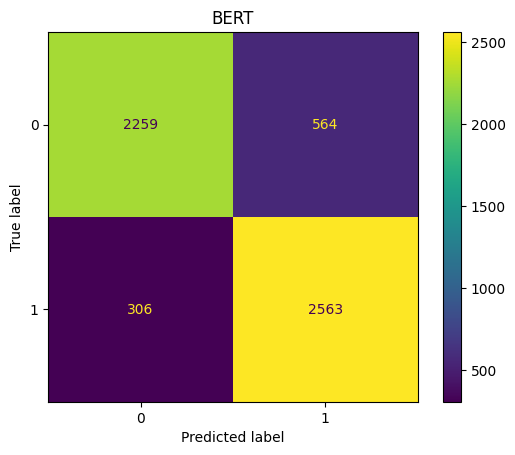

In [ ]:
y_pred = []
y_true = []

with torch.no_grad():
    for batch_input_ids, batch_attention_masks, batch_labels in data_loader(test_input_ids, test_attention_masks, test_labels, BATCH_SIZE):
        batch_input_ids = batch_input_ids.to(DEVICE)
        batch_attention_masks = batch_attention_masks.to(DEVICE)
        batch_labels = batch_labels.to(DEVICE)

        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        predictions = argmax(outputs.logits, dim=1)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(batch_labels.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix)
conf_matrix_display.plot()
plt.title("BERT")
plt.show()